# Practice 2: Targeted Poisoning of Horses with Frogs
We are given a binary classifier (model) trained to distinguish horses from frogs. The target is a specific horse sample that has not been seen by the victim model during training. We inject some modified poison (frog) samples into the training data so that the target horse will be recognized as a frog by the model trained on the poisoned data. The poisonous frogs comes from the tesing data owned by the adversary and are added to the benign training data owned by the victim. 

In [64]:
import torch
import numpy as np

criterion = torch.nn.BCEWithLogitsLoss()

DEVICE = torch.device("mps")  # Try "cuda" to train on GPU, "mps" for Apple Silicon, or "cpu" to train w/o GPU

MODEL_NUM = 3
BATCH_SIZE = 64
EPOCH_NUM = 10

print(
    f"Training on {DEVICE} using PyTorch {torch.__version__}"
)

Training on mps using PyTorch 2.1.2.post3


# Simple CNN model to distinguish two CIFAR classes
10 classes need more complex model.
The attack works better for more complex problems and when the base and target samples are more similar.

In [65]:
import torch.nn as nn
from torchvision import datasets
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # return_indices is only needed for Apple Silicon
        self.pool= nn.MaxPool2d(2, 2, return_indices=True)
        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(128)
        self.bn4=nn.BatchNorm2d(256)

        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
                
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)
                
        self.dropout = nn.Dropout(p=.50)

    def forward(self, x):
        x, _ = self.pool(F.relu(self.bn1(self.conv1(x))))
        x, _ = self.pool(F.relu(self.bn2(self.conv2(x))))
        x, _ = self.pool(F.relu(self.bn3(self.conv3(x))))
        x, _ = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x=self.fc3(x)
        return x


# Training, testing, selection and plotting

In [66]:
#from tqdm.notebook import tqdm
from tqdm import tqdm
import torch
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def select_classes(dataset, class1, class2):
    dataset.targets = np.array(dataset.targets)
    dataset.data = np.array(dataset.data)
    
    idxs1 = np.where(np.isin(dataset.targets, class1))[0]
    idxs1 = np.random.choice(idxs1, len(idxs1) // 2, replace=False)
   
    idxs2 = np.where(np.isin(dataset.targets, class2))[0]
    idxs2 = np.random.choice(idxs2, len(idxs2) // 2, replace=False)

    # binarize label 
    dataset.targets = np.array([x in class2 for x in dataset.targets])  
   
    return idxs1, idxs2

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# evaluate the network on the entire test set
def test(net, test_loader, criterion, device = DEVICE):
    """Evaluate the network on the entire test set."""
    total, correct, loss = 0, 0, 0
    net.eval()
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            output = net(inputs)
            loss += criterion(output, targets).item()  # sum up batch loss
            correct += (torch.round(torch.sigmoid(output)) == targets).sum().item()    
            total += targets.size(0)
            
    return correct / total, loss / total

# train a given model for a given number of epochs with a given loss function
def train(net, train_loader, epochs, criterion, device = DEVICE):
    """Train the network on the training set."""    
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    epoch_loss = 0.0
    
    correct = 0
    batch_num = len(train_loader)
    with tqdm(unit="batch", total=epochs * batch_num) as tepoch:
        for epoch in range(epochs):
            tepoch.set_description(f"Training epoch {epoch}")
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = net(inputs)

                correct = (torch.round(torch.sigmoid(outputs)) == targets).sum().item()
                accuracy = correct / BATCH_SIZE

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

                epoch_loss += loss.detach().item()
                tepoch.update(1)


def train_with_poison(training_data, X_train_p, y_train_p, val_loader, criterion, device = DEVICE):

    poison_data = torch.utils.data.TensorDataset(X_train_p, y_train_p)

    # do preprocessing on original training data (transform to tensor, etc.)
    tr_data_x = []
    tr_data_y = []
    for data_x, data_y in training_data:
        tr_data_x.append(data_x)
        tr_data_y.append(data_y)
    
    tr_data_x = torch.stack(tr_data_x)
    tr_data_y = torch.stack(tr_data_y)

    training_data = torch.utils.data.TensorDataset(tr_data_x, tr_data_y)
     
    # merge the original training data with the poisoned data
    poisoned_dataset = torch.utils.data.ConcatDataset([training_data, poison_data])

    # Shuffle the data before training
    _train_loader = torch.utils.data.DataLoader(poisoned_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # create model
    net_attacked = Net()
    net_attacked.to(device)
    net_attacked.train()

    train(net_attacked, _train_loader, EPOCH_NUM, criterion, device=device)
    return test(net_attacked, val_loader, criterion, device=device), net_attacked

def show_images(samples, title):
    plt.figure()
    samples = samples.cpu()
    grid = make_grid(samples)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title(title)


## Preparation: Train surrogate models with different random initializations of the model parameters
Create a new training data with two classes: Frog $\rightarrow$ 0, Horse $\rightarrow$ 1. We train three surrogate models denoted by $\{\theta_1, \theta_2, \theta_3\}$ on the victim's training data now (the available testing data is not enough to train good surrogates for this classification problem).

In [67]:
dataset_train = datasets.CIFAR10(root='./data', train=True,
                                        download=True)

dataset_test = datasets.CIFAR10(root='./data', train=False,
                                       download=True)

# frog -> 0, horse -> 1
test_idxs1, test_idxs2 = select_classes(dataset_test, [6], [7])
train_idxs1, train_idxs2 = select_classes(dataset_train, [6], [7])

# select target sample from class 1
target_sample = dataset_test.data[test_idxs2[0]]
target_orig_label = dataset_test.targets[test_idxs2[0]]

# remove victim sample from the test set
test_idxs2 = test_idxs2[1:]

train_idxs = np.concatenate([train_idxs1, train_idxs2])
test_idxs = np.concatenate([test_idxs1, test_idxs2])

# create training and test sets (we have numpy arrays)
dataset_train.data = dataset_train.data[train_idxs]
dataset_train.targets = dataset_train.targets[train_idxs]

dataset_test.data = dataset_test.data[test_idxs]
dataset_test.targets = dataset_test.targets[test_idxs]

target_sample = target_sample.transpose(2, 0, 1) / 255.0
x_train = dataset_train.data.transpose(0, 3, 1, 2) / 255.0
y_train = dataset_train.targets
x_test = dataset_test.data.transpose(0, 3, 1, 2) / 255.0
y_test = dataset_test.targets

print (x_train.shape, y_train.shape)
print ("Training size:", len(x_train))
print ("Test size:", len(x_test))

# convert to torch tensor
x_tensor_test = torch.tensor(x_test, dtype=torch.float32) # transform to torch tensor
y_tensor_test = torch.tensor(y_test[:, None], dtype=torch.float32)
x_tensor_train = torch.tensor(x_train, dtype=torch.float32) # transform to torch tensor
y_tensor_train = torch.tensor(y_train[:, None], dtype=torch.float32)

target_sample = torch.tensor(target_sample, dtype=torch.float32)
target_orig_label = torch.tensor([target_orig_label], dtype=torch.float32)

dataset_train = torch.utils.data.TensorDataset(x_tensor_train, y_tensor_train)
dataset_test = torch.utils.data.TensorDataset(x_tensor_test, y_tensor_test)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

models = []

for i in range(MODEL_NUM):
    # train the model from scratch
    # this initializes the model with random weights
    net_attacked = Net()
    net_attacked.to(DEVICE)
    net_attacked.train()
    
    _train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)

    train(net_attacked, _train_loader, EPOCH_NUM, criterion, device=DEVICE)
    accuracy, loss = test(net_attacked, test_loader, criterion, device=DEVICE)

    print(f"Validation loss: {loss}, accuracy: {accuracy}")

    models.append(net_attacked)

Files already downloaded and verified
Files already downloaded and verified
(5000, 3, 32, 32) (5000,)
Training size: 5000
Test size: 999


Training epoch 9: 100%|██████████| 790/790 [00:16<00:00, 48.41batch/s, accuracy=0.125, loss=7.61e-5] 


Validation loss: 0.003992742768398396, accuracy: 0.9429429429429429


Training epoch 9: 100%|██████████| 790/790 [00:15<00:00, 49.84batch/s, accuracy=0.109, loss=0.296]  


Validation loss: 0.0016931539589727486, accuracy: 0.9569569569569569


Training epoch 9: 100%|██████████| 790/790 [00:15<00:00, 50.64batch/s, accuracy=0.109, loss=0.338]   


Validation loss: 0.002715129145627116, accuracy: 0.9469469469469469


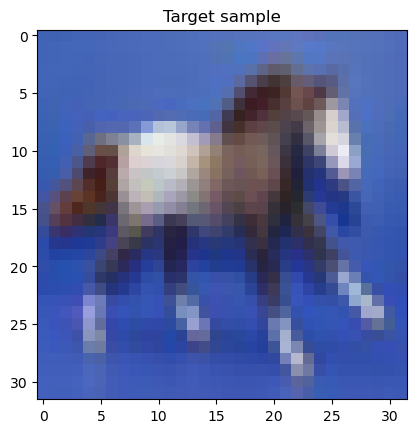

In [68]:
# plot the target sample

show_images(target_sample, "Target sample")

# Targeted poisoning attack
The goal is to misclassify a targeted horse sample (from class 1) to a frog (to class 0). The target is a testing sample and not part of the training data.
We select some frogs (base samples) from the testing data, modify their pixels such that they will produce very similar gradients to that of the targeted horse sample labelled as frog, and finally inject these modified samples into the training data.
These modified frog samples, which are correctly labelled as frog, mimic the gradients of the mislabeled target sample during training, even if the latter is not directly included in the training data.
Therefore, for the learning algorithm, it would seem like the targeted horse **labelled as frog** is in the training data. This is a clean-label attack since the injected frogs are correctly labeled as frogs and the mislabeled target is never injected into the training data. The injected base samples have invisibly modified pixels such that they indirectly and collectively represent the mislabeled target during training.

## Select base samples (frogs) from the test set. 
It's easier to poison horses with frogs than frogs with horses, because the attack is more likely to succeed (and need fewer poison samples) if the base samples are already similar to the target. In other words, it's easier to find brown frogs to poison a brown horse than a green horse to poison a green frog (unless the background behind a horse is very green); unlike green horses, green frogs are quite common in nature. The attack is also more likely to succeed if the target sample is difficult to classify with low confidence, that is, it is close to the decision boundary. 

Target original label: tensor([[1.]]), target adversarial label: tensor([[0.]])
base samples: torch.Size([40, 3, 32, 32])
base labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


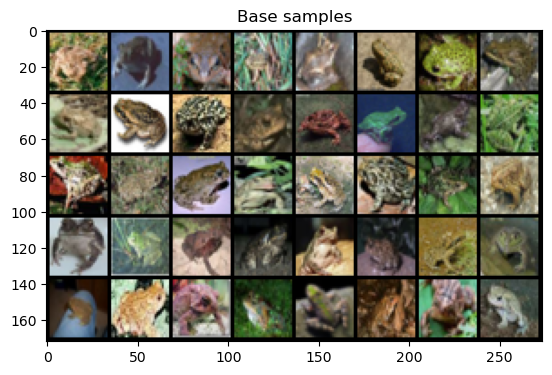

In [69]:
POISON_NUM = 40

def select_poison_sample(dataset, target_adv_label, poison_num=0):
    indices = [idx for idx, (_, target) in enumerate(dataset) if target == target_adv_label]
    based_idxs = np.random.choice(indices, poison_num, replace=False)

    return Subset(dataset, based_idxs)

# select the other label as adversarial label
target_orig_label = target_orig_label.unsqueeze(0)
target_adv_label = 1 - target_orig_label
print (f"Target original label: {target_orig_label}, target adversarial label: {target_adv_label}")

base_samples = select_poison_sample(dataset_train, target_adv_label, poison_num=POISON_NUM)
base_samples = torch.cat([victim[0].unsqueeze(0) for victim in base_samples], dim=0)
base_labels = target_adv_label.repeat(POISON_NUM, 1)

print (f"base samples: {base_samples.shape}")
print (f"base labels: {base_labels.view(-1)}")

show_images(base_samples, "Base samples")

## Poisoning recipe: Witches' brew
Solve  
$$\min_{\{\delta_1, \ldots, \delta_p\}} \frac{1}{3}\sum_{j=1}^3 \left(1 - \cos\angle\left(\nabla_\theta loss_f(\theta_j, x_t, y_t^{adv}),  \sum_{(x_i,y_i)\in D_t'}\nabla_\theta loss_f(\theta_j, x_i + \delta_i, y_i)\right)\right)\qquad s.t.\qquad \forall i: ||\delta_i||_\infty\leq \varepsilon$$
where $(x_t, y_t)$ is the horse to be misclassified as frog ($y_t^{adv}="\text{frog}"$), $D_t'$ is the set of base samples (frogs) coming from the test set that the adversary has. The goal is to compute a non-perceptible perturbation $\delta_i$ that should be added to these frogs so that they "gradient-wise" look like the targeted horse with the "frog" label for all the surrogate models $\{\theta_1, \theta_2, \theta_3\}$. The more surrogate models we have the more robust our attack will be. The reason is that the attacker does not know what exact model the victim will train on the poisoned data (even if the model architecture is known, the weights are initialized randomly and the data is processed in a random order that is usually unpredictable), hence the alignment is more likely to generalize to the victim's model if multiple surrogates are used to set this gradient alignment.

## Evaluate Poisoning on the Targeted Horse

In [70]:
from torch.nn.utils import parameters_to_vector
from functorch import grad

# used by loss_align (computes the MEAN loss over a batch)
def loss_BCE(model, params, buffers, samples, labels):
    return criterion(model(params, buffers, samples), labels)

# alignment loss between the target gradients and the mean gradients of the base samples
# (gradient is taken wrt the model parameters)
def loss_align(delta, target_grads, model, params, base_samples, base_labels, eps):
    # Move to GPU
    base_samples = base_samples.to(DEVICE)
    base_labels = base_labels.to(DEVICE)
    delta = delta.to(DEVICE)

    s = 0 
    for (param, buffers), target_grad in zip(params, target_grads):
        # tanh to ensure the perturbation [-eps, eps]
        # it is not absolutely necessary but it makes the optimization more stable since 
        # the objective function becomes continuous and bounded at the same time
        inputs = (model, param, buffers, base_samples + eps * torch.tanh(delta), base_labels)
        mean_grad = parameters_to_vector(grad(loss_BCE, argnums=1)(*inputs))

        s += 1 - torch.cosine_similarity(mean_grad, target_grad, dim=0) 

    return s / len(params)


In [71]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from functorch import grad, grad_and_value, make_functional_with_buffers

def wib_attack(models, target_sample, target_adv_label, base_samples_orig, eps=0.1, pgd_iternum=1000):
    target_sample = target_sample.to(DEVICE)
    target_adv_label = target_adv_label.to(DEVICE)

    base_samples = base_samples_orig

    poison_num = len(base_samples)  

    # clipping thresholds
    cl_lower = -base_samples
    cl_upper = 1 - base_samples

     # keep delta on cpu to save memory, initialize with random
    delta = torch.normal(0, 0.01, base_samples.shape)

    opt = optim.SGD([delta], lr=0.1)

    scheduler = ReduceLROnPlateau(opt, 'min', factor=0.1, patience=75, verbose=True)

    params, target_grads = [], []

    for i, net_adv in enumerate(models):
        net_adv.eval()
        target_logit = net_adv(target_sample)
        target_pred = torch.sigmoid(target_logit).item()

        print (f"Model: {i} Target prediction: {target_pred}")

        # compute target gradients per model
        model, param, buffers = make_functional_with_buffers(net_adv)

        fn = grad(loss_BCE, argnums=1) 
        target_grads.append(parameters_to_vector(fn(model, param, buffers, target_sample, target_adv_label)))

        params.append((param, buffers))

    for t in range(1, pgd_iternum + 1):

        # Periodically retrain from scratch on the poisoned data to check if the target is misclassified
        if t % 200 == 0:
            # Inject poisons
            noise = eps * torch.tanh(delta)
            noise = torch.clip(noise, cl_lower, cl_upper)
            base_samples = base_samples_orig + noise

            # Train from scratch
            (accuracy, loss), net_attacked = train_with_poison(dataset_train, base_samples, base_labels, test_loader, criterion, device=DEVICE)
            print(f"Validation loss: {loss}, accuracy: {accuracy}")

            # Check the prediction of the target sample
            net_attacked.eval()
            target_logit = net_attacked(target_sample)
            target_pred = torch.sigmoid(target_logit).item()
            print (f"Target prediction: {target_pred} Logit: {target_logit.item()}")

            # Stop if target is misclassified
            if round(target_pred) == target_adv_label:
                print (f"Target is misclassified!")
                return True, noise
            
        fn = grad_and_value(loss_align, argnums=0)

        # delta is computed on batches of the base samples to fit into VRAM
        # (we can also optimize for all samples at once if POISON_NUM is not too large)
        order = np.random.permutation(poison_num)
        total_loss = 0
        delta.grad = torch.zeros_like(delta)
        for i in range(0, poison_num, BATCH_SIZE):
            idxs = order[i:i+BATCH_SIZE]
            delta.grad[idxs], loss = fn(delta[idxs], target_grads, model, params, base_samples_orig[idxs], base_labels[idxs], eps)
            total_loss += loss.item()

        # since we have L_inf constraint, we use sign of the gradient (see PGD evasion attack for more details)
        delta.grad = torch.sign(delta.grad)
        opt.step()

        mean_loss = total_loss / poison_num

        if t % 10 == 0:
            print(f"--- Round: {t} Alignment loss: {mean_loss} ---")

        scheduler.step(mean_loss)
    return False, None

print (target_sample.shape)
success, noise = wib_attack(models, target_sample.unsqueeze(0), target_adv_label, base_samples, eps=0.1, pgd_iternum=1000)

print ("Attack success:", success)  


torch.Size([3, 32, 32])
Model: 0 Target prediction: 0.9953815937042236
Model: 1 Target prediction: 0.8847704529762268
Model: 2 Target prediction: 0.9918658137321472


--- Round: 10 Alignment loss: 0.0017690563574433327 ---
--- Round: 20 Alignment loss: 0.001114907395094633 ---
--- Round: 30 Alignment loss: 0.000908063817769289 ---
--- Round: 40 Alignment loss: 0.000795048475265503 ---
--- Round: 50 Alignment loss: 0.0007181510329246521 ---
--- Round: 60 Alignment loss: 0.0006771897431463003 ---
--- Round: 70 Alignment loss: 0.0006865402217954397 ---
--- Round: 80 Alignment loss: 0.000634416937828064 ---
--- Round: 90 Alignment loss: 0.0006201833486557007 ---
--- Round: 100 Alignment loss: 0.0006598556879907847 ---
--- Round: 110 Alignment loss: 0.0006843278650194406 ---
--- Round: 120 Alignment loss: 0.0006526738405227661 ---
--- Round: 130 Alignment loss: 0.0006416598800569773 ---
--- Round: 140 Alignment loss: 0.000652619218453765 ---
--- Round: 150 Alignment loss: 0.0006538406014442444 ---
--- Round: 160 Alignment loss: 0.0006494646426290273 ---
Epoch 00166: reducing learning rate of group 0 to 1.0000e-02.
--- Round: 170 Alignment loss: 0.0006461

Training epoch 9: 100%|██████████| 790/790 [00:16<00:00, 48.88batch/s, accuracy=0.75, loss=0.00255]


Validation loss: 0.002502727906804185, accuracy: 0.958958958958959
Target prediction: 0.9859532713890076 Logit: 4.251217365264893
--- Round: 200 Alignment loss: 0.0006341179367154836 ---
--- Round: 210 Alignment loss: 0.0006409426685422658 ---
--- Round: 220 Alignment loss: 0.0006326471921056509 ---
--- Round: 230 Alignment loss: 0.0006161352153867483 ---
--- Round: 240 Alignment loss: 0.0006385097745805979 ---
--- Round: 250 Alignment loss: 0.0006329720374196768 ---
--- Round: 260 Alignment loss: 0.0006416454911231994 ---
--- Round: 270 Alignment loss: 0.0006420259829610586 ---
--- Round: 280 Alignment loss: 0.000639053201302886 ---
--- Round: 290 Alignment loss: 0.0006559824105352163 ---
--- Round: 300 Alignment loss: 0.0006535837892442942 ---
--- Round: 310 Alignment loss: 0.0006444603204727173 ---
--- Round: 320 Alignment loss: 0.0006486897822469473 ---
Epoch 00322: reducing learning rate of group 0 to 1.0000e-03.
--- Round: 330 Alignment loss: 0.0006375089287757874 ---
--- Round: 

Training epoch 9: 100%|██████████| 790/790 [00:16<00:00, 49.36batch/s, accuracy=0.75, loss=0.00465]


Validation loss: 0.003413957264926937, accuracy: 0.9479479479479479
Target prediction: 0.7929068803787231 Logit: 1.3425370454788208
--- Round: 400 Alignment loss: 0.0006552273873239756 ---
--- Round: 410 Alignment loss: 0.000647309934720397 ---
--- Round: 420 Alignment loss: 0.0006462047342211009 ---
--- Round: 430 Alignment loss: 0.0006401151418685913 ---
--- Round: 440 Alignment loss: 0.0006449098233133555 ---
--- Round: 450 Alignment loss: 0.00063899508677423 ---
--- Round: 460 Alignment loss: 0.0006467049475759268 ---
--- Round: 470 Alignment loss: 0.00064820796251297 ---
Epoch 00474: reducing learning rate of group 0 to 1.0000e-05.
--- Round: 480 Alignment loss: 0.0006450816988945007 ---
--- Round: 490 Alignment loss: 0.0006451904773712158 ---
--- Round: 500 Alignment loss: 0.0006399214267730713 ---
--- Round: 510 Alignment loss: 0.0006469617132097482 ---
--- Round: 520 Alignment loss: 0.0006476635579019784 ---
--- Round: 530 Alignment loss: 0.0006537775043398142 ---
--- Round: 54

Training epoch 9: 100%|██████████| 790/790 [00:16<00:00, 48.76batch/s, accuracy=0.734, loss=0.0343]


Validation loss: 0.004688301460222677, accuracy: 0.924924924924925
Target prediction: 0.9785779714584351 Logit: 3.82167911529541
--- Round: 600 Alignment loss: 0.0006528998259454965 ---
--- Round: 610 Alignment loss: 0.0006452818866819144 ---
--- Round: 620 Alignment loss: 0.0006513267755508423 ---
Epoch 00626: reducing learning rate of group 0 to 1.0000e-07.
--- Round: 630 Alignment loss: 0.0006477212067693472 ---
--- Round: 640 Alignment loss: 0.0006476283073425293 ---
--- Round: 650 Alignment loss: 0.0006468594074249268 ---
--- Round: 660 Alignment loss: 0.0006485512014478445 ---
--- Round: 670 Alignment loss: 0.0006534879561513662 ---
--- Round: 680 Alignment loss: 0.0006491909269243478 ---
--- Round: 690 Alignment loss: 0.0006502156611531973 ---
--- Round: 700 Alignment loss: 0.0006477400660514831 ---
Epoch 00702: reducing learning rate of group 0 to 1.0000e-08.
--- Round: 710 Alignment loss: 0.0006547108292579651 ---
--- Round: 720 Alignment loss: 0.0006557305809110403 ---
--- Ro

Training epoch 9: 100%|██████████| 790/790 [00:15<00:00, 50.20batch/s, accuracy=0.734, loss=0.0531]


Validation loss: 0.004286552142646458, accuracy: 0.9359359359359359
Target prediction: 0.10421445965766907 Logit: -2.151250123977661
Target is misclassified!
Attack success: True


## Show the poison and the poisonous frogs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


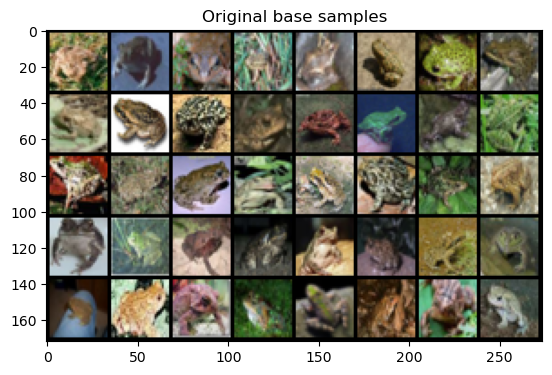

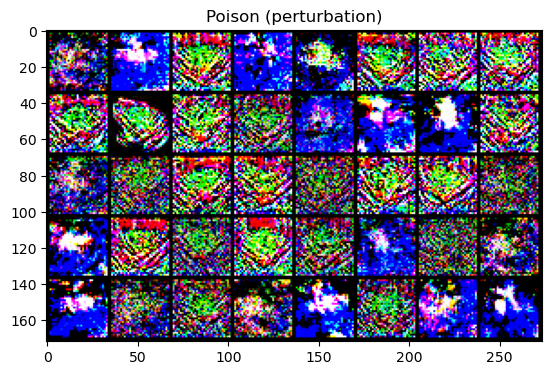

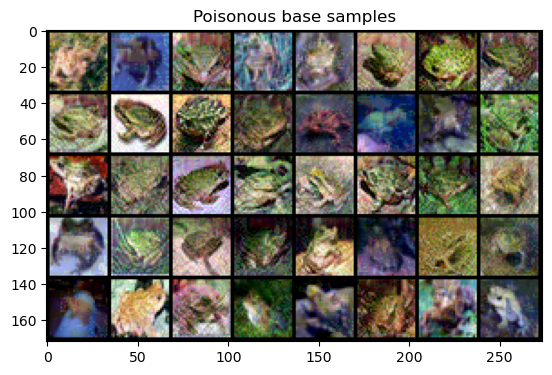

In [79]:
show_images(base_samples, "Original base samples")
show_images(noise*10, "Poison (perturbation)")
show_images(base_samples + noise, "Poisonous base samples")
